In [ ]:
!pip install mne==1.10.2 scikit-learn pandas matplotlib seaborn


In [ ]:
from pathlib import Path
import mne
from mne.datasets import sample

# Get dataset path (as Path object)
data_path = sample.data_path()
raw_file = data_path / 'MEG' / 'sample' / 'sample_audvis_raw.fif'

# Load only EEG channels
raw = mne.io.read_raw_fif(raw_file, preload=True)
raw.pick_types(meg=False, eeg=True)  # Only EEG channels

# Print EEG info
print(raw.info)


Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
<Info | 19 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 59 EEG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 1

In [ ]:
# Filter EEG between 1-40 Hz
raw.filter(1., 40., fir_design='firwin')

# Check info again
print(raw.info)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1983 samples (3.302 s)

<Info | 19 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 59 EEG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 

In [ ]:
# Create fixed-length epochs of 2 seconds, preload data
epochs = mne.make_fixed_length_epochs(raw, duration=2., overlap=0., preload=True)

# Now you can safely check number of epochs
print("Number of epochs:", len(epochs))
print("Epoch data shape (epochs x channels x samples):", epochs.get_data().shape)


Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 138 events and 1201 original time points ...
0 bad epochs dropped
Number of epochs: 138
Epoch data shape (epochs x channels x samples): (138, 59, 1201)


In [ ]:
import numpy as np

def extract_features_from_epoch(epoch_data, sfreq=raw.info['sfreq']):
    """
    Input: epoch_data -> 2D array (channels x samples)
    Output: 1D feature vector per epoch
    """
    features = []
    for ch_data in epoch_data:
        # FFT
        fft_vals = np.fft.rfft(ch_data)
        fft_freq = np.fft.rfftfreq(len(ch_data), 1/sfreq)

        # Alpha (8-12 Hz) power
        alpha_power = np.mean(np.abs(fft_vals[(fft_freq>=8) & (fft_freq<=12)])**2)

        # Beta (13-30 Hz) power
        beta_power = np.mean(np.abs(fft_vals[(fft_freq>=13) & (fft_freq<=30)])**2)

        # Alpha/Beta ratio
        ratio = alpha_power / beta_power if beta_power != 0 else 0

        # Statistical features
        mean_val = np.mean(ch_data)
        var_val = np.var(ch_data)

        features.append([alpha_power, beta_power, ratio, mean_val, var_val])

    # Flatten features of all channels
    return np.array(features).flatten()

# Prepare feature matrix X
X = []
for ep in epochs.get_data():
    X.append(extract_features_from_epoch(ep))
X = np.array(X)

print("Feature matrix shape:", X.shape)


Feature matrix shape: (138, 295)


In [ ]:
# First half epochs = relaxed (0), second half = focused (1)
y = np.array([0]*(len(X)//2) + [1]*(len(X)-len(X)//2))
print("Labels shape:", y.shape)


Labels shape: (138,)


Accuracy: 0.7857142857142857


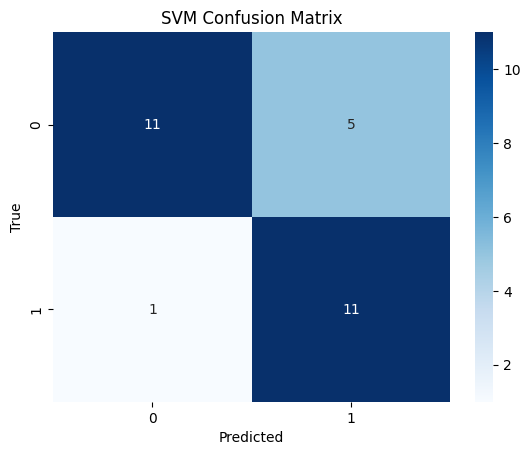

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear SVM
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.show()


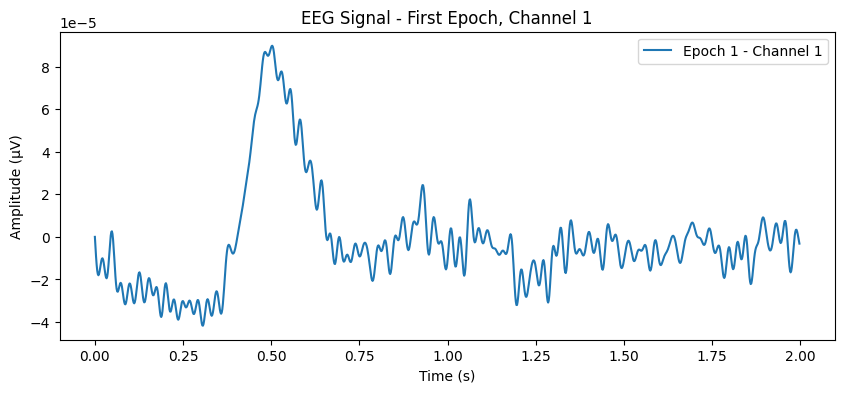

In [ ]:
# Plot first channel of first epoch
eeg_data = epochs.get_data()  # epochs x channels x samples
sfreq = raw.info['sfreq']
times = np.arange(eeg_data.shape[2]) / sfreq

plt.figure(figsize=(10,4))
plt.plot(times, eeg_data[0,0,:], label='Epoch 1 - Channel 1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title('EEG Signal - First Epoch, Channel 1')
plt.legend()
plt.show()
